# CIFAR-10에 대해 일반 네트워크와 ResNet을 구현

In [1]:
#데이터 준비

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
#Tensorflow가 활용할 GPU가 장착되어 있는지 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
import os
urllib3.disable_warnings()

#데이터셋 다운로드과정의 프로그레스바 없애는 코드
#tfds.disable_progress_bar()   

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    data_dir = os.getenv('HOME')+'/aiffel/CIFAR_10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [7]:
#Tensorflow 데이터셋 feature 정보 확인 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [8]:
# 데이터의 개수 확인 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [4]:
#정규화 함수
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [5]:
#정규화 적용 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
ds_info.features["label"].num_classes

10

In [12]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

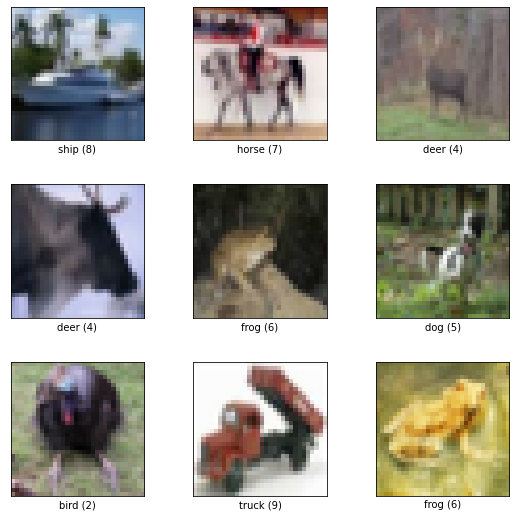

In [13]:
fig = tfds.show_examples(ds_train, ds_info)

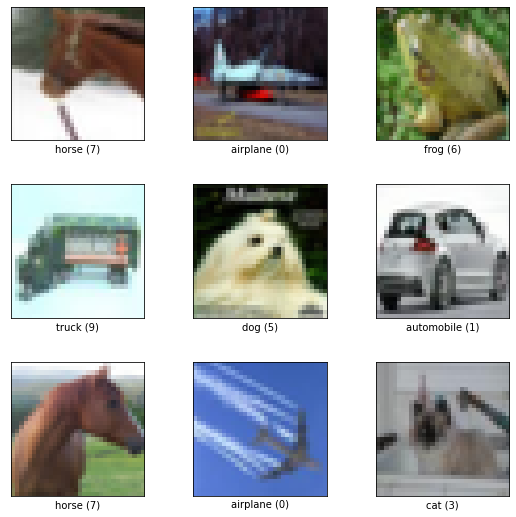

In [14]:
fig = tfds.show_examples(ds_test, ds_info)

### 블록만들기
- 딥러닝 모델에서 이렇게 주요 구조를 모듈화 시켜 조금씩 바꾸어 쓸 수 있는 단위를 블록(block) 이라 함.

### VGG-16과 VGG-19의 기본 구조가 되는 블록 만들기
- VGG의 블록은 개략적으로 CNN 레이어 여러 개와 Max pooling 레이어 한 개로 되어있음.
- CNN은 모두 커널 크기가 3x3 라는 대표적인 특징을 가짐.
- 록 내 CNN 레이어의 채널은 하나로 유지되지만 서로 다른 블록 간 CNN 레이어의 채널 수는 다를 수 있음.
- 블록에 따라서 CNN 레이어의 개수 또한 달라짐.
- 블록의 마지막에는 항상 Max Pooling 레이어가 붙기 때문에 블록은 CNN 레이어 여러 개와 Max pooling 레이어 한 개로 이루어질 것이며, CNN의 레이어 수와 채널을 조절할 수 있어야 함.

In [6]:
#function for building VGG Block

def build_vgg_block(input_layer, num_cnn=3, channel=64, block_num=1, ):
    #block_num은 레이어의 이름을 붙여주기 위해서 추가
    #input_shape은 summary 출력 위해 추가
    
    #입력 레이어
    x = input_layer

    #CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}')(x)    

    #Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling')(x)

    return x

In [7]:
#input_layer에 추가
#이 입력 레이어를 인자로 받아 build_vgg_block() 는 블록의 레이어를 build하고 출력값을 얻을 수 있음.

#keras Model 클래스에서 input과 output 정의 후 블록 모델 확인
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   #입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    #VGG 블록 생성

In [8]:
#블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


### VGG-16

In [9]:
#VGG 모델 자체를 생성하는 함수.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인.
    
    input_layer = keras.layers.Input(shape=input_shape)  #input layer 생성
    output = input_layer
    
    #config list들의 길이만큼 반복해서 블록을 생성.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [10]:
#기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 되는 것.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

###  VGG-19

In [11]:
#configuration을 바꿔서 VGG-19를 만들 수 있음.

#원하는 블록의 설계에 따라 매개변수로 리스트를 전달.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

### VGG-16과 VGG-19 비교

In [12]:
#데이터셋 로드
BATCH_SIZE = 32
EPOCH = 20

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    data_dir = os.getenv('HOME')+'/aiffel/CIFAR_10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [13]:
#VGG_16 훈련
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
1562/1562 [==============================] - 142s 80ms/step - loss: 2.0557 - accuracy: 0.2325 - val_loss: 1.5659 - val_accuracy: 0.4244
Epoch 2/20
1562/1562 [==============================] - 110s 71ms/step - loss: 1.5742 - accuracy: 0.4297 - val_loss: 1.4106 - val_accuracy: 0.4924
Epoch 3/20
1562/1562 [==============================] - 111s 71ms/step - loss: 1.3827 - accuracy: 0.5035 - val_loss: 1.3279 - val_accuracy: 0.5238
Epoch 4/20
1562/1562 [==============================] - 112s 71ms/step - loss: 1.2518 - accuracy: 0.5526 - val_loss: 1.1193 - val_accuracy: 0.6105
Epoch 5/20
1562/1562 [==============================] - 112s 72ms/step - loss: 1.1342 - accuracy: 0.5996 - val_loss: 1.0961 - val_accuracy: 0.6155
Epoch 6/20
1562/1562 [==============================] - 112s 72ms/step - loss: 1.0347 - accuracy: 0.6369 - val_loss: 1.0245 - val_accuracy: 0.6384
Epoch 7/20
1562/1562 [==============================] - 112s 72ms/step - loss: 0.9413 - accuracy: 0.6676 - val_loss: 1

In [14]:
#VGG_19 훈련
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
1562/1562 [==============================] - 142s 89ms/step - loss: 2.1006 - accuracy: 0.2117 - val_loss: 1.6431 - val_accuracy: 0.4081
Epoch 2/20
1562/1562 [==============================] - 139s 89ms/step - loss: 1.6226 - accuracy: 0.4116 - val_loss: 1.4580 - val_accuracy: 0.4651
Epoch 3/20
1562/1562 [==============================] - 139s 89ms/step - loss: 1.4413 - accuracy: 0.4807 - val_loss: 1.3196 - val_accuracy: 0.5377
Epoch 4/20
1562/1562 [==============================] - 139s 89ms/step - loss: 1.2964 - accuracy: 0.5319 - val_loss: 1.3076 - val_accuracy: 0.5353
Epoch 5/20
1562/1562 [==============================] - 139s 89ms/step - loss: 1.1719 - accuracy: 0.5817 - val_loss: 1.1049 - val_accuracy: 0.6095
Epoch 6/20
1562/1562 [==============================] - 139s 89ms/step - loss: 1.0707 - accuracy: 0.6218 - val_loss: 1.0827 - val_accuracy: 0.6249
Epoch 7/20
1562/1562 [==============================] - 139s 89ms/step - loss: 0.9721 - accuracy: 0.6578 - val_loss: 1

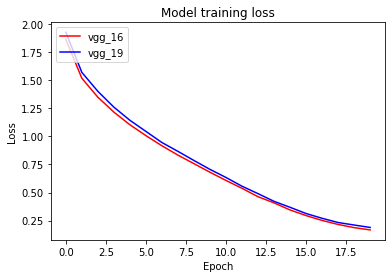

In [15]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

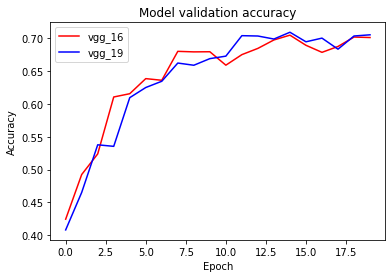

In [16]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()